In [61]:

# quandly for financial data
import quandl
# pandas for data manipulation
import pandas as pd
# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import fbprophet
%matplotlib inline

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Data Cleaning 

In [ ]:
quandl.ApiConfig.api_key = 'xLMoQS8dcFcwGWDyckQW'

# Retrieve TSLA data from Quandl
dfFB1 = quandl.get('WIKI/FB')
dfAMZN1 = quandl.get('WIKI/AMZN')
dfAAPL1 = quandl.get('WIKI/AAPL')
dfNFLX1 = quandl.get('WIKI/NFLX')
dfGOOGL1 = quandl.get('WIKI/GOOGL')

In [ ]:
dfFB1.reset_index(level=0, inplace = True)
dfAMZN1.reset_index(level=0, inplace = True)
dfAAPL1.reset_index(level=0, inplace = True)
dfNFLX1.reset_index(level=0, inplace = True)
dfGOOGL1.reset_index(level=0, inplace = True)

In [85]:
dfSP5001 = pd.read_csv('data/daily/SP500.csv')
dfSP5001.rename(index=str, columns={'DATE':'Date', 'SP500': 'Adj. Close'}, inplace=True)
dfSP5001 = dfSP5001[dfSP5001 != '.']
dfSP5001['Adj. Close'] = pd.to_numeric(dfSP5001['Adj. Close'])
dfSPcap = pd.read_csv('data/daily/SP500MarketCap.csv')

In [86]:
# convert df['Date'] columns to date type select dates where all stocks were represented in the index
df_list = [dfFB1, dfAMZN1, dfAAPL1, dfNFLX1, dfGOOGL1, dfSP5001]
start_date = pd.to_datetime('04-04-2014')
for df in df_list:
    df['Date'] = pd.to_datetime(df['Date'])

dfFB = dfFB1[dfFB1['Date'] >= start_date][['Date', 'Adj. Close']]
dfAMZN = dfAMZN1[dfAMZN1['Date'] >= start_date][['Date', 'Adj. Close']]
dfAAPL = dfAAPL1[dfAAPL1['Date'] >= start_date][['Date', 'Adj. Close']]
dfNFLX = dfNFLX1[dfNFLX1['Date'] >= start_date][['Date', 'Adj. Close']]
dfGOOGL = dfGOOGL1[dfGOOGL1['Date'] >= start_date][['Date', 'Adj. Close']]
dfSP500 = dfSP5001[dfSP5001['Date'] >= start_date]
dfSP500 = dfSP500.dropna(axis=0, how='any')

In [64]:
# Add shares outstanding dictionaries
FB_shares = {2014: ((1975722473 + 574020314)+(2236333833 + 562677981))/2, 2015:((2236333833 + 562677981)+(2294939865 + 551340611))/2, 2016:((2294939865 + 551340611) + (2355168103 + 534813231))/2, 2017:((2355168103 + 534813231) + (2395921635 + 509079123))/2, 2018:(2395921635 + 509079123)}

AMZN_shares = {2014: (459264535 + 464383939)/2, 2015:(464383939 + 470842035)/2, 2016:(470842035 + 477170618)/2, 2017:(477170618 + 484107183)/2, 2018: 484107183}


AAPL_shares = {2014: (899738000*7 + 5864840000)/2, 2015:(5864840000 + 5575331000)/2, 2016:( 5575331000 + 5332313000)/2, 2017:(5332313000 + 5134312000)/2, 2018: 5134312000}

NFLX_shares = {2014:(59807236*7 + 60498082*7)/2 , 2015: 428081221, 2016:(428081221 + 430411593)/2, 2017:(430411593 + 433948461)/2, 2018: 433948461}

GOOGL_shares = {2014: (286938352 + 53018898 + 340665532), 2015:(292580627 + 50199837 + 345539300), 2016:((292580627 + 50199837 + 345539300) + (297117506 + 47369687 + 346933134))/2, 2017:((297117506 + 47369687 + 346933134) + (298492525 + 46961288 + 349843717))/2, 2018: (298492525 + 46961288 + 349843717)}

In [65]:
# Create a year column from the Date column and then create a cap column pulling from the dictionary of shares outstanding

dfFB['Year'] = dfFB.Date.dt.year
dfFB['cap'] = 0
dfFB['cap'] = dfFB['Year'].apply(lambda x: FB_shares.get(x))
dfFB['cap'] = (dfFB['cap'] * dfFB['Adj. Close'])/1e9

dfAMZN['Year'] = dfAMZN.Date.dt.year
dfAMZN['cap'] = 0
dfAMZN['cap'] = dfAMZN['Year'].apply(lambda x: AMZN_shares.get(x))
dfAMZN['cap'] = (dfAMZN['cap'] * dfAMZN['Adj. Close'])/1e9

dfAAPL['Year'] = dfAAPL.Date.dt.year
dfAAPL['cap'] = 0
dfAAPL['cap'] = dfAAPL['Year'].apply(lambda x: AAPL_shares.get(x))
dfAAPL['cap'] = (dfAAPL['cap'] * dfAAPL['Adj. Close'])/1e9

dfNFLX['Year'] = dfNFLX.Date.dt.year
dfNFLX['cap'] = 0
dfNFLX['cap'] = dfNFLX['Year'].apply(lambda x: NFLX_shares.get(x))
dfNFLX['cap'] = (dfNFLX['cap'] * dfNFLX['Adj. Close'])/1e9

dfGOOGL['Year'] = dfGOOGL.Date.dt.year
dfGOOGL['cap'] = 0
dfGOOGL['cap'] = dfGOOGL['Year'].apply(lambda x: GOOGL_shares.get(x))
dfGOOGL['cap'] = (dfGOOGL['cap'] * dfGOOGL['Adj. Close'])/1e9

In [66]:
# Create cap df and merge FAANG component caps
dfSPcap = dfSPcap[['Date', 'Total_Market_Cap']]
dfSPcap['Date'] = pd.to_datetime(dfSPcap['Date'])
dfSPcap['Total_Market_Cap'] = dfSPcap['Total_Market_Cap'].str.replace(',','')
dfSPcap['Total_Market_Cap'] = pd.to_numeric(dfSPcap['Total_Market_Cap'])
dfSPcap['Total_Market_Cap'] = dfSPcap['Total_Market_Cap']/1e3
dfSPcap = dfSPcap[dfSPcap['Date'] >= start_date]
dfSPcap = dfSPcap.merge(dfFB[['cap','Date']], how='left', on='Date')
dfSPcap.rename(index=str, columns={'cap':'FB_cap'}, inplace=True)
dfSPcap = dfSPcap.merge(dfAMZN[['cap','Date']], how='left', on='Date')
dfSPcap.rename(index=str, columns={'cap':'AMZN_cap'}, inplace=True)
dfSPcap = dfSPcap.merge(dfAAPL[['cap','Date']], how='left', on='Date')
dfSPcap.rename(index=str, columns={'cap':'AAPL_cap'}, inplace=True)
dfSPcap = dfSPcap.merge(dfNFLX[['cap','Date']], how='left', on='Date')
dfSPcap.rename(index=str, columns={'cap':'NFLX_cap'}, inplace=True)
dfSPcap = dfSPcap.merge(dfGOOGL[['cap','Date']], how='left', on='Date')
dfSPcap.rename(index=str, columns={'cap':'GOOGL_cap'}, inplace=True)
# new column for total FAANG cap
dfSPcap['FAANG_cap'] = dfSPcap['FB_cap'] + dfSPcap['AMZN_cap'] + dfSPcap['AAPL_cap'] + dfSPcap['NFLX_cap'] + dfSPcap['GOOGL_cap']
# new column for total FAANG cap percentage
dfSPcap['FAANG_cap_%'] = dfSPcap['FAANG_cap']/ dfSPcap['Total_Market_Cap']
# new column for year
dfSPcap['Year'] = dfSPcap.Date.dt.year
# new column for complement of FAAANG cap for stacked bar
dfSPcap['Rest_of_SP'] = dfSPcap['Total_Market_Cap'] - dfSPcap['FAANG_cap']

### Visualization 

In [67]:
# Correlation df
dfFAANG = dfFB.filter(['Date', 'Adj. Close'])
dfFAANG = dfFAANG.merge(dfAMZN.filter(['Date', 'Adj. Close']), how='left', on='Date')
dfFAANG.rename(index=str, columns={'Adj. Close_x':'FB', 'Adj. Close_y': 'AMZN'}, inplace=True)
dfFAANG = dfFAANG.merge(dfAAPL.filter(['Date', 'Adj. Close']), how='left', on='Date')
dfFAANG.rename(index=str, columns={'Adj. Close':'AAPL'}, inplace=True)
dfFAANG = dfFAANG.merge(dfNFLX.filter(['Date', 'Adj. Close']), how='left', on='Date')
dfFAANG.rename(index=str, columns={'Adj. Close':'NFLX'}, inplace=True)
dfFAANG = dfFAANG.merge(dfGOOGL.filter(['Date', 'Adj. Close']), how='left', on='Date')
dfFAANG.rename(index=str, columns={'Adj. Close':'GOOGL'}, inplace=True)
dfFAANG = dfFAANG.merge(dfSP500.filter(['Date', 'Adj. Close']), how='left', on='Date')
dfFAANG.rename(index=str, columns={'Adj. Close':'SP500'}, inplace=True)
dfFAANG = dfFAANG.drop(['Date'],axis=1)

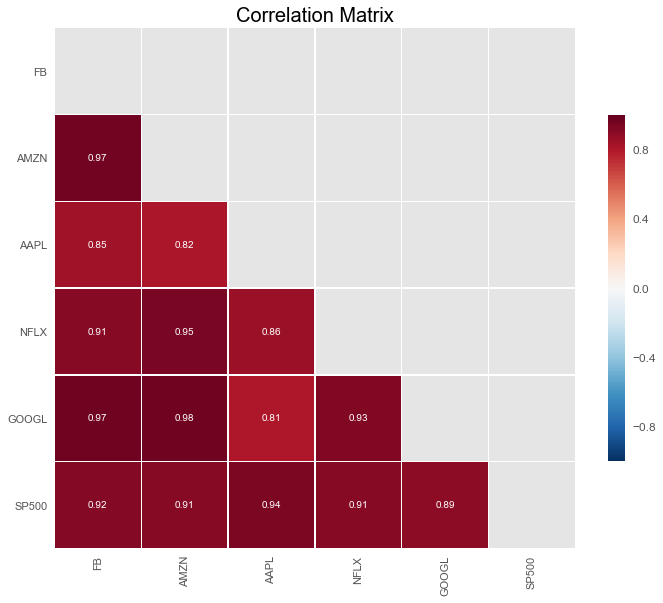

In [53]:
plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')
## Correlation Matrix

def corr_heatmap_with_values(df):
    corr = dfFAANG.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(10,10))
#     cmap = sns.color_palette('coolwarm')
    sns.heatmap(corr, mask=mask, center=0, square=True, linewidths=.5,
                yticklabels=True, annot=True, fmt='.2f', cbar_kws={'shrink':.5})
    plt.title('Correlation Matrix', fontsize=20)
    plt.xticks(rotation=90, fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    plt.tight_layout()
# cmap = sns.color_palette("hls", 8)
corr_heatmap_with_values(dfFAANG)

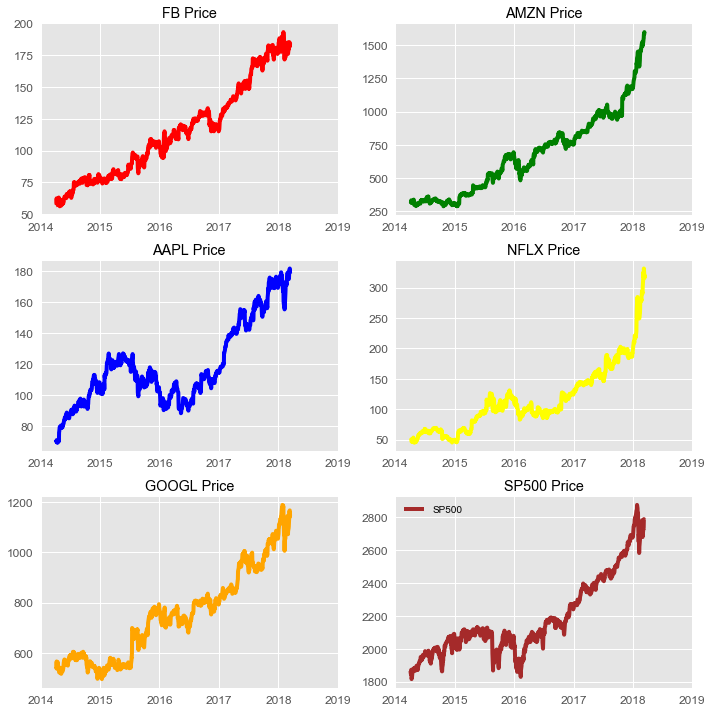

In [57]:
### Plot Price Action of FAANG and S&P 500
df_list = [dfFB, dfAMZN, dfAAPL, dfNFLX, dfGOOGL, dfSP500]
# Setup date locator items for plotting/ x-axis
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

symbols = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL', 'SP500']
fig, axes = plt.subplots(3, 2, figsize=(10,10))
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'brown']
axes = axes.ravel()
for idx, df in enumerate(df_list):
    ax = axes[idx]
    symbol = symbols[idx]
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    datemin = datetime.date(df.Date.min().year, 1, 1)
    datemax = datetime.date(df.Date.max().year + 1, 1, 1)
    ax.set_xlim(datemin, datemax)
    ax.plot(df.Date, df['Adj. Close'], label=f'{symbol}', color=colors[idx])
    ax.set_title(f'{symbol} Price')
plt.legend()
plt.tight_layout()

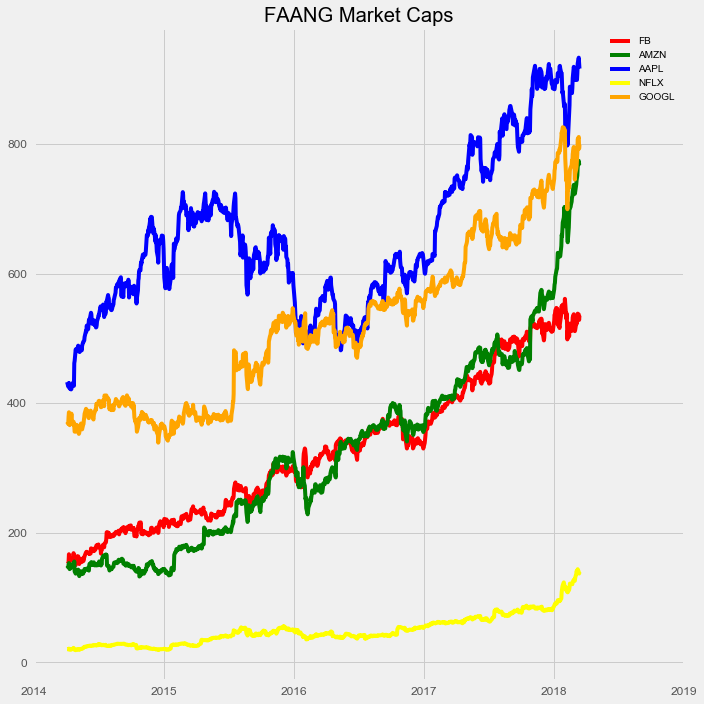

In [69]:
### Plot Market Caps of FAANG
df_list = [dfFB, dfAMZN, dfAAPL, dfNFLX, dfGOOGL]
# Setup date locator items for plotting/ x-axis
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

symbols = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL']
fig, ax = plt.subplots(1, 1, figsize=(10,10))
colors = ['red', 'green', 'blue', 'yellow', 'orange']
for idx, df in enumerate(df_list):
    symbol = symbols[idx]
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    datemin = datetime.date(df.Date.min().year, 1, 1)
    datemax = datetime.date(df.Date.max().year + 1, 1, 1)
    ax.set_xlim(datemin, datemax)
    ax.plot(df.Date, df['cap'], label=f'{symbol}', color=colors[idx])
ax.set_title('FAANG Market Caps')


plt.legend()
plt.tight_layout()

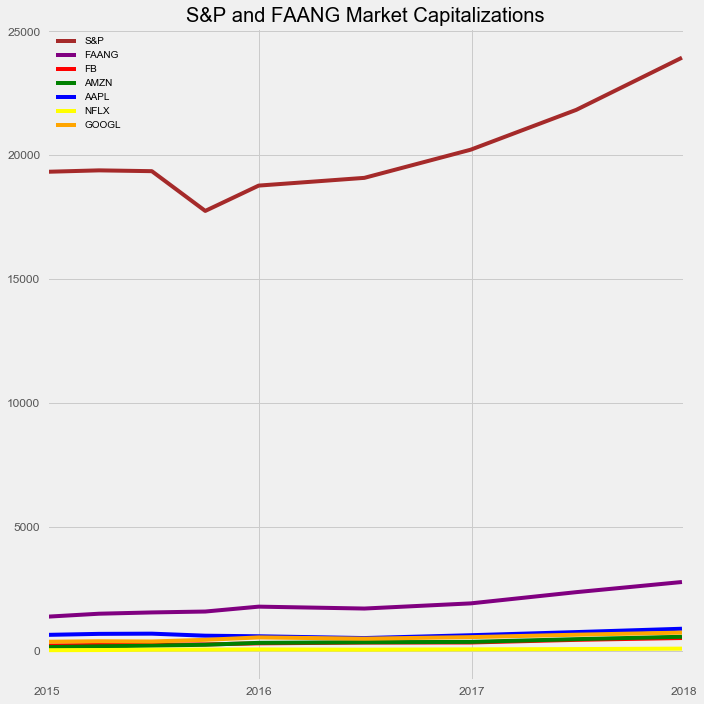

In [72]:
# ## Plot total SP cap with FAANG caps
#
plot_list = ['Total_Market_Cap', 'FAANG_cap', 'FB_cap', 'AMZN_cap', 'AAPL_cap', 'NFLX_cap', 'GOOGL_cap']
symbols = ['S&P', 'FAANG', 'FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL']


fig, ax = plt.subplots(1, 1, figsize=(10,10))
colors = ['brown', 'purple', 'red', 'green', 'blue', 'yellow', 'orange']

for idx, col in enumerate(plot_list):
    symbol = symbols[idx]
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    datemin = datetime.date(dfSPcap.Date.min().year + 1, 1, 1)
    datemax = datetime.date(dfSPcap.Date.max().year + 1, 1, 1)
    ax.set_xlim(datemin, datemax)
    ax.plot(dfSPcap.Date, dfSPcap[col], label=f'{symbol}', color=colors[idx])

ax.set_title(f'S&P and FAANG Market Capitalizations')
plt.legend()
plt.tight_layout()

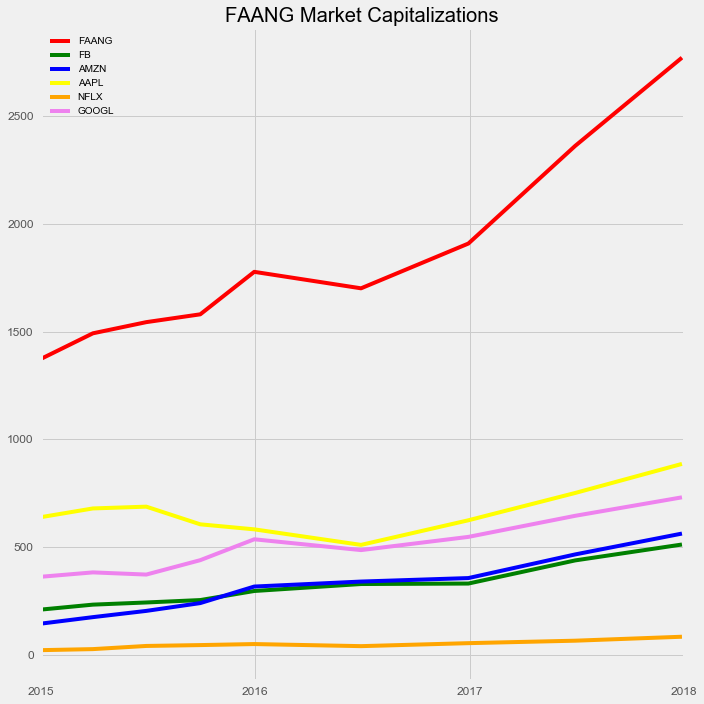

In [74]:
###Plot FAANG individuals and total
#
plot_list = ['FAANG_cap', 'FB_cap', 'AMZN_cap', 'AAPL_cap', 'NFLX_cap', 'GOOGL_cap']
symbols = ['FAANG', 'FB', 'AMZN', 'AAPL', 'NFLX', 'GOOGL']

fig, ax = plt.subplots(1, 1, figsize=(10,10))
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'violet']

for idx, col in enumerate(plot_list):
    symbol = symbols[idx]
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    datemin = datetime.date(dfSPcap.Date.min().year + 1, 1, 1)
    datemax = datetime.date(dfSPcap.Date.max().year + 1, 1, 1)
    ax.set_xlim(datemin, datemax)
    ax.plot(dfSPcap.Date, dfSPcap[col], label=f'{symbol}', color=colors[idx])

ax.set_title('FAANG Market Capitalizations')
plt.legend()
plt.tight_layout()

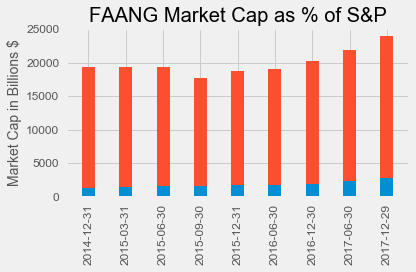

In [81]:
### S&P cap to FAANG Cap as stacked bars

width = 0.35
cap_dates = dfSPcap[['Date', 'FAANG_cap', 'Total_Market_Cap']]
cap_dates = dfSPcap.sort_values(['Date'])
x = np.arange(9)
p1 = plt.bar(x, cap_dates['FAANG_cap'], width)
p2 = plt.bar(x, cap_dates['Rest_of_SP'], width, bottom=cap_dates['FAANG_cap'])

plt.ylabel('Market Cap in Billions $')
plt.title('FAANG Market Cap as % of S&P')
plt.xticks(x, ('2014-12-31', '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31', '2016-06-30', '2016-12-30', '2017-06-30', '2017-12-29'), rotation='vertical')
plt.yticks(np.arange(0, 30000, 5000))
plt.tight_layout()

In [79]:
# Prophet requires columns ds (Date) and y (value)
dfFB = dfFB.rename(columns={'Date': 'ds', 'cap': 'y'})
dfAMZN = dfAMZN.rename(columns={'Date': 'ds', 'cap': 'y'})
dfAAPL = dfAAPL.rename(columns={'Date': 'ds', 'cap': 'y'})
dfNFLX = dfNFLX.rename(columns={'Date': 'ds', 'cap': 'y'})
dfGOOGL = dfGOOGL.rename(columns={'Date': 'ds', 'cap': 'y'})

In [88]:
dfSP500 = dfSP500.rename(columns={'Date': 'ds', 'Adj. Close': 'y'})

In [ ]:
# Make the prophet models and fit on the data
# changepoint_prior_scale can be changed to achieve a better fit
fb_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
fb_prophet.fit(dfFB)
amzn_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
amzn_prophet.fit(dfAMZN)
aapl_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
aapl_prophet.fit(dfAAPL)
nflx_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
nflx_prophet.fit(dfNFLX)
googl_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
googl_prophet.fit(dfGOOGL)

In [89]:
sp_prophet = fbprophet.Prophet(changepoint_prior_scale=0.05)
sp_prophet.fit(dfSP500)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Make a future dataframe for 2 years, Make predictions
fb_forecast = fb_prophet.make_future_dataframe(periods=365 * 5, freq='D')
fb_forecast = fb_prophet.predict(fb_forecast)

amzn_forecast = amzn_prophet.make_future_dataframe(periods=365*5, freq='D')
amzn_forecast = amzn_prophet.predict(amzn_forecast)

aapl_forecast = aapl_prophet.make_future_dataframe(periods=365*5, freq='D')
aapl_forecast = aapl_prophet.predict(aapl_forecast)

nflx_forecast = nflx_prophet.make_future_dataframe(periods=365*5, freq='D')
nflx_forecast = nflx_prophet.predict(nflx_forecast)

googl_forecast = googl_prophet.make_future_dataframe(periods=365*5, freq='D')
googl_forecast = googl_prophet.predict(googl_forecast)

In [90]:
sp_forecast = sp_prophet.make_future_dataframe(periods=365*5, freq='D')
sp_forecast = sp_prophet.predict(sp_forecast)

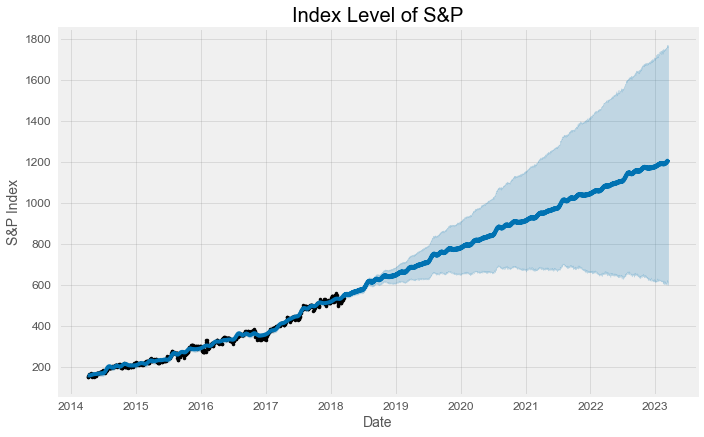

In [93]:
fb_prophet.plot(fb_forecast, xlabel = 'Date', ylabel = 'S&P Index')
plt.title('Index Level of S&P');

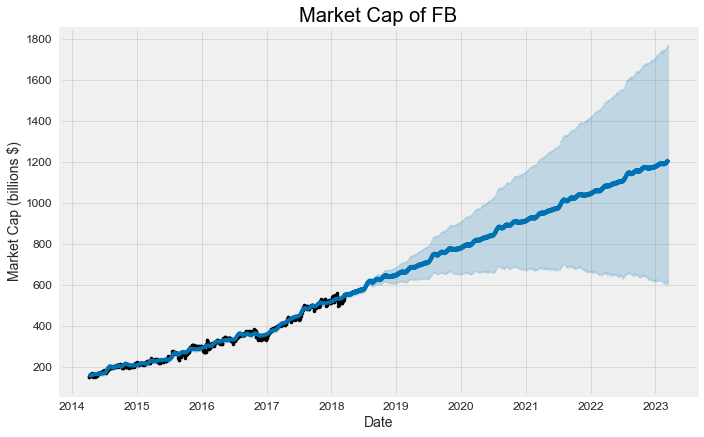

In [22]:
fb_prophet.plot(fb_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of FB');

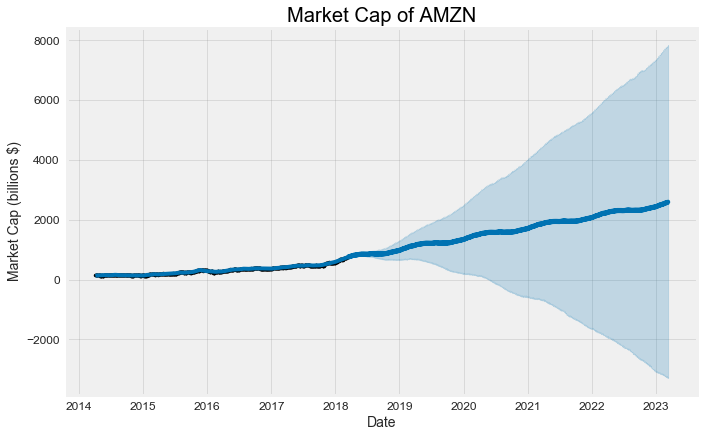

In [27]:
amzn_prophet.plot(amzn_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of AMZN');

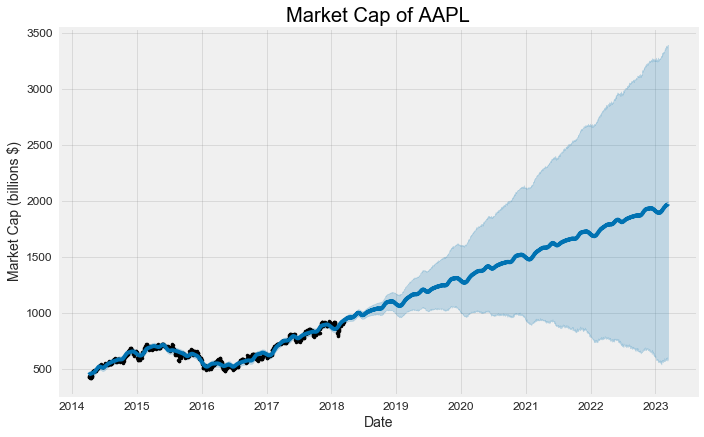

In [28]:
aapl_prophet.plot(aapl_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of AAPL');

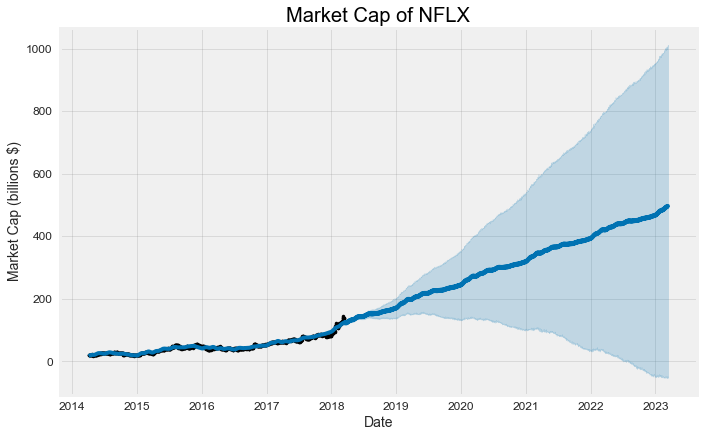

In [29]:
nflx_prophet.plot(nflx_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of NFLX');

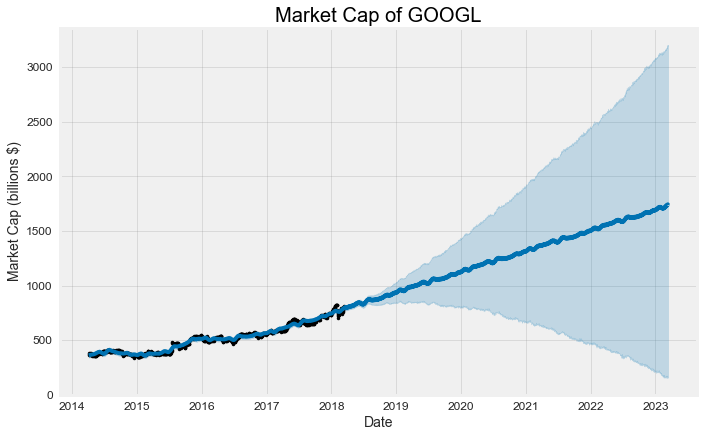

In [30]:
googl_prophet.plot(googl_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of GOOGL');

In [32]:
googl_forecast.head()


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2014-04-04,359.614145,359.614145,359.614145,340.618824,385.539776,2.248204,2.248204,2.248204,2.248204,2.248204,2.248204,-1.993115,-1.993115,-1.993115,4.241319,4.241319,4.241319,361.862349
1,2014-04-07,360.698842,360.698842,360.698842,341.150257,386.470498,2.525602,2.525602,2.525602,2.525602,2.525602,2.525602,-1.960166,-1.960166,-1.960166,4.485767,4.485767,4.485767,363.224444
2,2014-04-08,361.060408,361.060408,361.060408,341.110472,386.178457,2.514117,2.514117,2.514117,2.514117,2.514117,2.514117,-2.061603,-2.061603,-2.061603,4.575720,4.575720,4.575720,363.574525
3,2014-04-09,361.421974,361.421974,361.421974,343.084940,387.536924,3.209969,3.209969,3.209969,3.209969,3.209969,3.209969,-1.450292,-1.450292,-1.450292,4.660261,4.660261,4.660261,364.631943
4,2014-04-10,361.783540,361.783540,361.783540,342.236390,387.742476,2.391621,2.391621,2.391621,2.391621,2.391621,2.391621,-2.342684,-2.342684,-2.342684,4.734305,4.734305,4.734305,364.175161


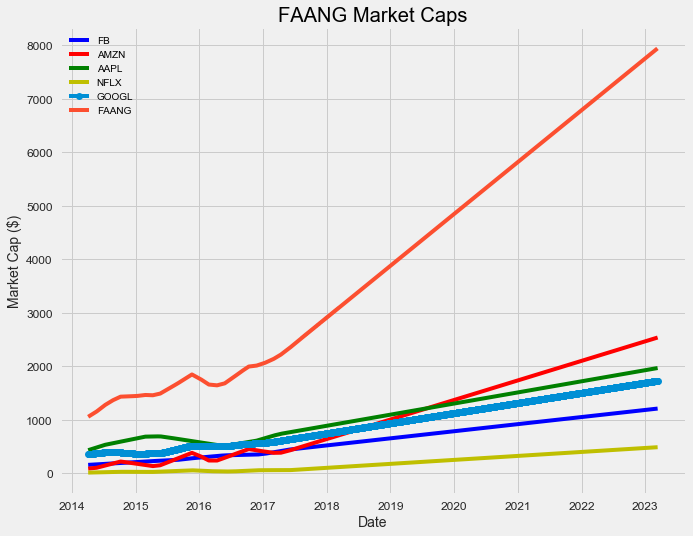

In [44]:
plt.figure(figsize=(10, 8))
plt.plot(fb_forecast['ds'], fb_forecast['trend'], 'b-', label='FB')
plt.plot(amzn_forecast['ds'], amzn_forecast['trend'], 'r-', label='AMZN')
plt.plot(aapl_forecast['ds'], aapl_forecast['trend'], 'g-', label='AAPL')
plt.plot(nflx_forecast['ds'], nflx_forecast['trend'], 'y-', label='NFLX')
plt.plot(googl_forecast['ds'], googl_forecast['trend'], 'o-', label='GOOGL')
plt.plot(googl_forecast['ds'], (fb_forecast['trend']+amzn_forecast['trend']+aapl_forecast['trend']+nflx_forecast['trend']+googl_forecast['trend']), '-', label='FAANG')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Market Cap ($)')
plt.title('FAANG Market Caps');